# Capstone Three: Data Wrangling and EDA

Currently, pathologists manually classify blood cells, which is time-consuming and prone to human error. Artificial Intelligence could speed up this process, leading to faster disease diagnosis. Blood cell classification is important because it plays a key role in medical diagnosis, treatment planning, and disease monitoring. Blood cell abnormalities are linked to serious conditions such as: Leukemia, Anemia, Infections, etc. Hospitals and labs handle thousands of samples daily. Automating this process could reduce operational costs through cutting down labor intensive manual work. By developing a model for blood cell classification, we could improve medical efficiency, enhance patient care, and increase hospital/lab efficiency. This portion of the project will focus on wrangling the blood cell data and exploratory data analysis of the blood cell images in our dataset.

## Imports

In [5]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from scipy.ndimage import gaussian_filter, map_coordinates
import seaborn as sns
from skimage.filters import gabor
import pickle

2025-02-09 22:55:50.275006: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading blood cell images and annotations

In [7]:
IMAGE_DIR = "BCC_data/images/"

In [8]:
df = pd.read_csv("BCC_data/annotations.csv")

In [9]:
df["image"] = df["image"].apply(lambda x: os.path.join(IMAGE_DIR, x))

In [10]:
df.head()

,image,xmin,ymin,xmax,ymax,label
0,BCC_data/images/image-100.png,0.000000,0.000000,25.190198,40.816803,rbc
1,BCC_data/images/image-100.png,15.010502,0.000000,68.337223,23.527421,rbc
2,BCC_data/images/image-100.png,25.017503,16.021004,78.374562,73.735123,rbc
3,BCC_data/images/image-100.png,75.565928,1.061844,140.248541,45.591599,rbc
4,BCC_data/images/image-100.png,77.483081,23.290548,131.936989,74.806301,rbc


## Plotting images

In [12]:
def plot_images(images, titles=None, suptitle=None, overlay=False, colorbar='default'):
    num_images = len(images)

    if overlay:
        fig, ax = plt.subplots()
        for image in images:
            ax.imshow(image)
        if colorbar != None:
          fig.colorbar(ax.imshow(image))
        if suptitle:
            plt.suptitle(suptitle)
    else:
        fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))
        if num_images == 1:
            axes = [axes]
        for i, image in enumerate(images):
            axes[i].imshow(image)
            if titles:
                axes[i].set_title(titles[i])
            if colorbar == 'multi' and not (image.ndim == 3 and image.shape[2] == 3):
                fig.colorbar(axes[i].imshow(image), ax=axes[i])
            elif colorbar == 'single' and not (image.ndim == 3 and image.shape[2] == 3):
               fig.colorbar(axes[i].imshow(image), ax=axes)
        if suptitle:
            plt.suptitle(suptitle)
    plt.show()

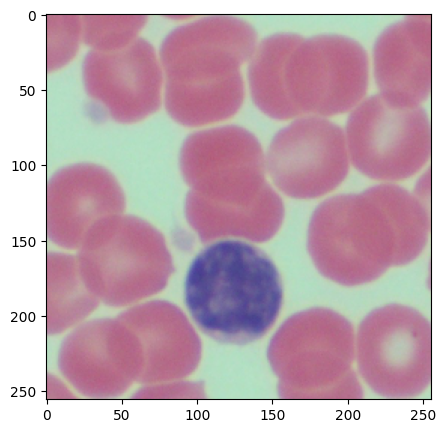

In [13]:
get_images = [np.array(Image.open(img_path)) for img_path in df.image[0:1]]
plot_images(get_images)

We can see from the first image that there are many red blood cells, one white blood cell and even a few dim platelets.

## Data Augmentation

We will be applying an elastic transformation to the images. Blood cells often have distorted shapes and therefore to create realistic distortions we have decided to apply elastic deformation.

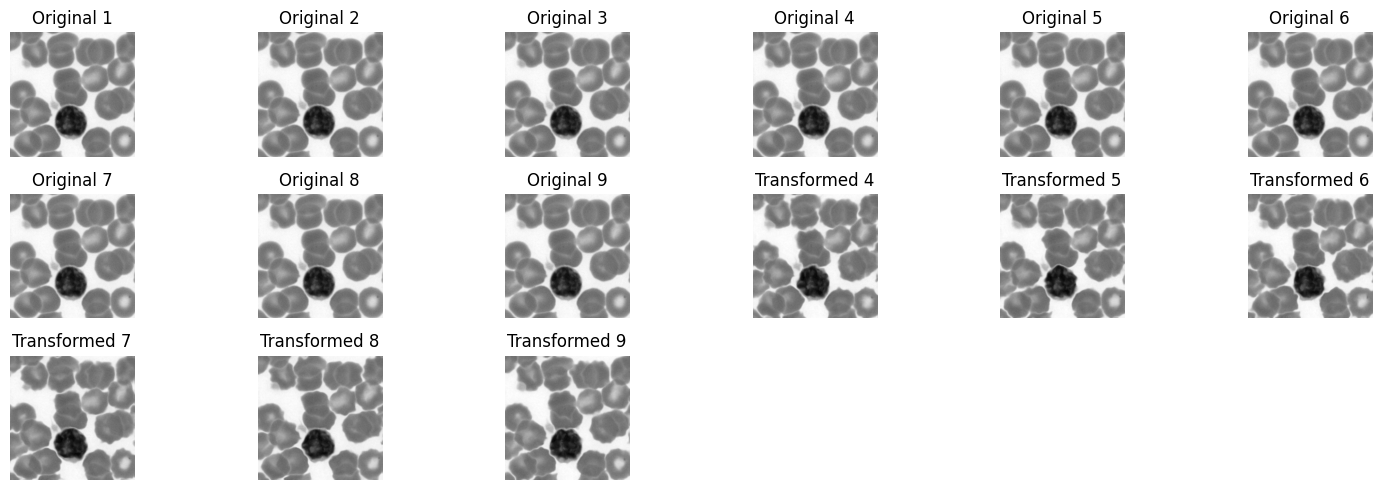

In [17]:
def elastic_transform(image, alpha, sigma):
    """Apply elastic transformation to an image."""
    random_state = np.random.RandomState(None)

    # Generate random displacement fields
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="nearest", truncate=2)
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="nearest", truncate=2)
    
    # Apply scaling factor (alpha)
    dz = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="nearest", truncate=2)
    
    # Create a meshgrid of coordinates
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    
    # Apply displacement to the coordinates
    distored_x = np.clip(x + alpha * dx, 0, shape[1] - 1)
    distored_y = np.clip(y + alpha * dy, 0, shape[0] - 1)
    
    # Map original image to the distorted grid
    distorted_image = map_coordinates(image, [distored_y, distored_x], order=1, mode='reflect')

    return distorted_image

# Load the image paths from the DataFrame 
image_paths = df['image']
alpha = 30  # Intensity of deformation
sigma = 4   # Smoothness of deformation

# Create a list to store the transformed images
transformed_images = []

# Loop through image paths, load the images, and apply elastic transformation
for img_path in image_paths:
    # Ensure the path exists
    if os.path.exists(img_path):
        # Read the image using OpenCV
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Apply elastic deformation
        transformed_image = elastic_transform(image, alpha, sigma)
        transformed_images.append(transformed_image)

# Display the original and transformed images
plt.figure(figsize=(15, 5))
for i, (orig_img, transformed_img) in enumerate(zip(image_paths[0:9], transformed_images)):
    plt.subplot(3, 6, i + 1)
    plt.imshow(cv2.imread(orig_img, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title(f"Original {i+1}")
    plt.axis('off')
    
    plt.subplot(3, 6, i + 7)
    plt.imshow(transformed_img, cmap='gray')
    plt.title(f"Transformed {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

As we can see above the textures of the cells have been significantly highlighted with the elastic transformation.

## Exploratory Data Analysis

We can see that there are significantly more red blood cells accounted for than white blood cells. This dataset seems to be an imbalanced dataset.

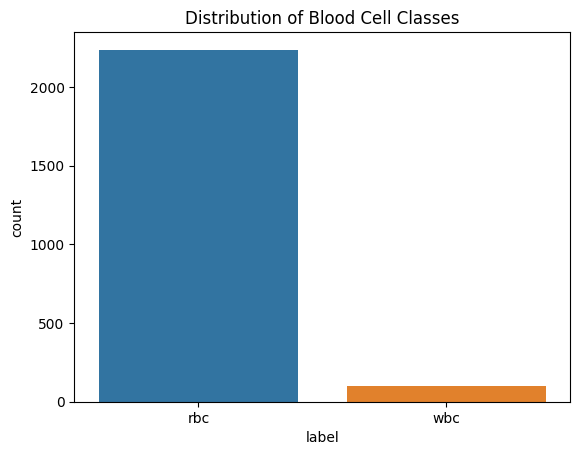

In [24]:
sns.countplot(x='label', data=df) 
plt.title('Distribution of Blood Cell Classes')
plt.show()

In [25]:
print(f"Original Image Size: {image.shape}")
print(f"Transformed Image Size: {transformed_image.shape}")

Original Image Size: (256, 256)
Transformed Image Size: (256, 256)


The images still maintained the same aspect ratio and size. This will be important for our model later, which will expect input images to have the same size.

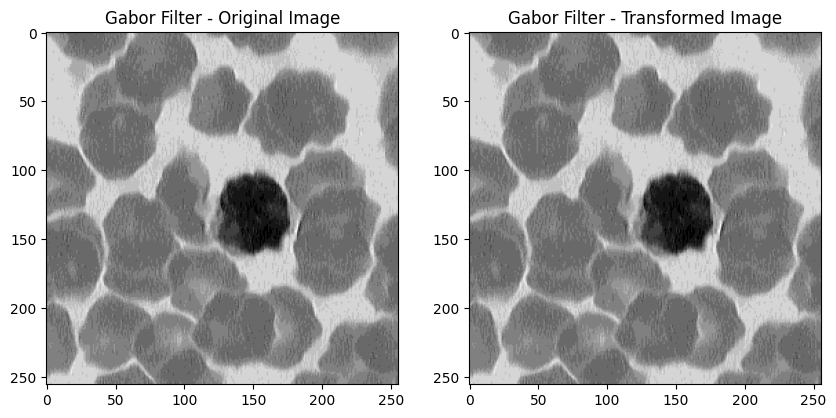

In [27]:
# Apply Gabor filter to both original and transformed images
original_filtered, _ = gabor(image, frequency=0.6)
transformed_filtered, _ = gabor(transformed_image, frequency=0.6)

# Display the filtered images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_filtered, cmap='gray')
ax[0].set_title('Gabor Filter - Original Image')
ax[1].imshow(transformed_filtered, cmap='gray')
ax[1].set_title('Gabor Filter - Transformed Image')
plt.show()

Lastly the gabor filter was applied to the original and transformed image for texture analysis, edge detection and feature extraction. We can see here that the granularity and fine details of the cells appear more pronounced. The filtered images reveal enhanced edges, resulting in sharper object boundaries. The darker white blood cell in the center is more distinct. The transformed image exhibits slightly different textural responses which could be due to directional filtering effects. These images also focus on the primary structures (the blood cells) and reduce the background. If there are any platelets in this image then they are faded out. This will be important to note as we move forward in the preprocessing and modeling portions of the project. 

## Summary

Our dataset has a variety of blood cell images that will make the model robust later on. The images contain red, white, and platelet blood cells. The platelets are more dim and transparent compared to the other cells and may be faded out with more filtering that can be done later in the preprocessing and modeling portions of the project, which will have to be taken note of later as we move throughout the process. The elastic transformation improved our images robustness since blood cells often have natural shape deformations. The transformation along with the gabor filtering will assist the model in detecting textures and edges. It was also realized that there is a large class imbalance between the red and white blood cells. This class imbalance will be dealt with in the preprocessing phase with either undersampling, SMOTE, or synthetic data generation. Further exploration could include segmentation such as otsu's thresholding.

In [31]:
with open("BCC_data/transformed_images.pkl", "wb") as f:
    pickle.dump(transformed_images, f)

print("Images saved as transformed_images.pkl")

Images saved as transformed_images.pkl


In [32]:
output_folder = "BCC_data/Transformed_images"
os.makedirs(output_folder, exist_ok=True)

# Save each image in the list
for i, img in enumerate(transformed_images):
    file_path = os.path.join(output_folder, f"image_{i}.png") 
    cv2.imwrite(file_path, img)

print(f"Saved {len(transformed_images)} images in '{output_folder}/'")

Saved 2340 images in 'BCC_data/Transformed_images/'
